In [56]:
import numpy as np
import scipy.io as sio
import h5py
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import math

In [2]:
data_path = Path('../data')

## process Arkansas group .mat file
This version of .mat file requires `h5py` module. It is a streaming data format: when instantiating the data object via `h5py.File()` it doesn't load the data into memory yet. Data are loaded into memory only when asked.

Data stored in this format as key value pairs.

In [3]:
d19 = h5py.File(data_path / 'TDB_19_4D.mat')

<ipython-input-3-d7a3812fadd0>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  d19 = h5py.File(data_path / 'TDB_19_4D.mat')


In [4]:
d19.keys()

<KeysViewHDF5 ['TDB_19_4D']>

In [20]:
# peak the actual data (under key TDB_19_4D)
d19['TDB_19_4D'].shape

(5, 747, 750, 487)

In [8]:
data = d19['TDB_19_4D'][0, :, :, 0]

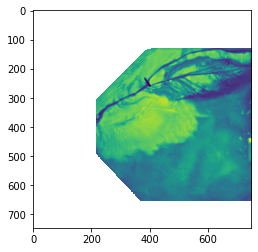

In [9]:
plt.imshow(data)

### trim data
We will remove rows and cols that are completely null to trim the data down before trying to crop the images.

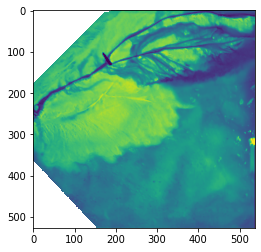

In [25]:
mask = np.all(np.isnan(data), axis=1)
mask2 = np.all(np.isnan(data), axis=0)
# data_trim = data[~mask][:, ~mask2]
plt.imshow(data[~mask][:, ~mask2])

In [26]:
mask.shape

(747,)

In [27]:
trim_data = d19['TDB_19_4D'][:, :, :, :5]

In [48]:
trim_data2 = trim_data[:, ~mask, :, :][:, :, ~mask2, :]

In [49]:
trim_data2.shape

(5, 527, 537, 5)

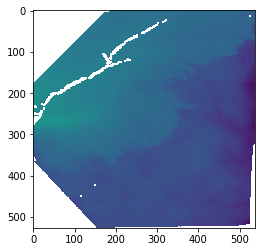

In [50]:
plt.imshow(trim_data2[-1, :, :, 2])

/home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.0030e+03, 2.7809e+04, 9.5005e+04, 8.7679e+04, 3.7851e+04,
        1.6610e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-61.6 , -35.19,  -8.78,  17.63,  44.04,  70.45,  96.86, 123.27,
        149.68, 176.09, 202.5 ]),
 <BarContainer object of 10 artists>)

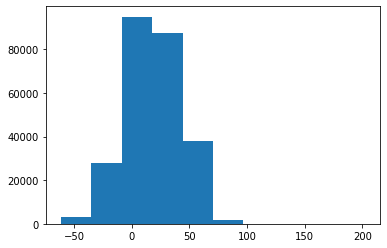

In [52]:
plt.hist(trim_data2[-1, :, :, 2].ravel())

### fill nan
The trimmed images still got nan that needs to be filled. The RGB space and mask channel uses 0 to fill nulls. The elevation uses minimum value -50 to fill the nulls.

In [53]:
trim_data2[:-1][np.isnan(trim_data2[:-1])] = 0
trim_data2[-1][np.isnan(trim_data2[-1])] = -50

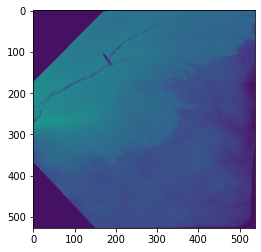

In [54]:
plt.imshow(trim_data2[-1, :, :, 2])

In [55]:
n_images = d19['TDB_19_4D'].shape[-1]

for i in range(math.ceil(n_images/100)):
    istart, iend = i*100, (i+1)*100
    iend = min(n_images, iend)
    array = d19['TDB_19_4D'][:, :, :, istart:iend]
    # trim
    array = array[:, ~mask, :, :][:, :, ~mask2, :]
    # fill null
    array[:-1][np.isnan(array[:-1])] = 0
    array[-1][np.isnan(array[-1])] = -50

    # moves the channel to last dim
    array = np.moveaxis(array, 0, -1)
    # move batch size to first dim
    array = np.moveaxis(array, -2, 0)
    np.save(f'tbd_19_part_{i}.npy', array)

## process Tulane group data

In [5]:
fnames = [f for f in os.listdir(data_path) if f.endswith('.mat')]
data = {}
for fname in fnames:
    d_name = fname.split('.')[0]
    print(f'loading {d_name}')
    try:
        data[d_name] = h5py.File(data_path / fname, 'r')
    except OSError:
        data[d_name] = sio.loadmat(data_path / fname)

loading RGB_19_2_wet
loading TDWB_19_2_chanMaps
loading TDWB_19_2_SLOPE
loading TDB_17_data
loading ZD_19_2_wet
loading TDB_13_data


In [6]:
data['TDB_17_data'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'B_maps', 'C_maps', 'G_maps', 'R_maps', 'Z_maps'])

In [7]:
data['TDB_17_data']['B_maps'].shape

(796, 522, 560)

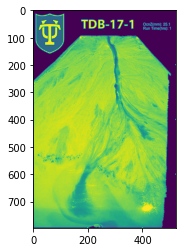

In [8]:
plt.imshow(data['TDB_17_data']['G_maps'][:, :, 0])

In [10]:
n_images = 560

In [21]:
for i in range(7):
    istart, iend = i*100, (i+1)*100
    iend = min(n_images, iend)
    idx = data['TDB_17_data']['Z_maps'][:, :, istart:iend] == 0
    tbd_17 = []
    for col in ['R_maps', 'G_maps', 'B_maps']:
        dcopy = data['TDB_17_data'][col][:, :, istart:iend].copy()
        dcopy[idx] = 0
        tbd_17.append(dcopy)

    tbd_17.append(data['TDB_17_data']['Z_maps'][:, :, istart:iend])
    tbd_17.append(data['TDB_17_data']['C_maps'][:, :, istart:iend])
    tbd_17_array = np.array(tbd_17)
    tbd_17_array = np.moveaxis(tbd_17_array, -1, 0)
    tbd_17_array = np.moveaxis(tbd_17_array, 1, -1)
    np.save(f'tbd_17_part_{i}.npy', tbd_17_array)

## data processing to do:

- Tulane data needs to rid of out of bound pixels (some contains logo and metadata needs to be painted over) (not if we just use the whole image as training/target)
- size of image gonna matter, the context of a local vs big picture can be quite different, especially consideringd the masks are a subset of all channels
- we probably have to split image to enrich the dataset. We will see.

In [26]:
rgb_19_2_wet = data['RGB_19_2_wet']['RGB_19_2_wet']

In [27]:
rgb_19_2_wet.shape

(3, 560, 747, 750)

In [28]:
rgb_19_2_wet

<HDF5 dataset "RGB_19_2_wet": shape (3, 560, 747, 750), type "<f8">

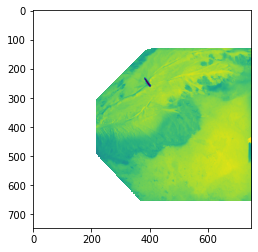

In [31]:
plt.imshow(rgb_19_2_wet[1, 0, :, :])

In [32]:
data['TDWB_19_2_chanMaps']['TDWB_19_2_chanMaps'].shape

(560, 747, 750)

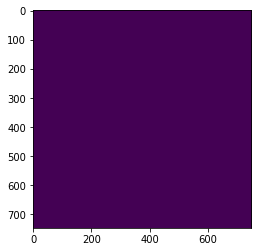

In [33]:
plt.imshow(data['TDWB_19_2_chanMaps']['TDWB_19_2_chanMaps'][100, :, :])

(array([     0.,      0.,      0.,      0.,      0., 560250.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

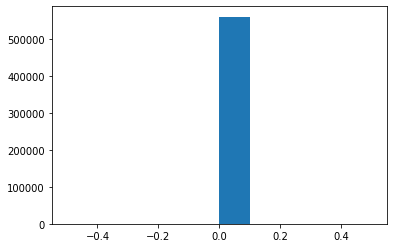

In [35]:
plt.hist(data['TDWB_19_2_chanMaps']['TDWB_19_2_chanMaps'][100, :, :].ravel())